In [1]:
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.utils.data as Data
from tqdm import tqdm

import numpy as np

In [2]:
USE_CUDA = True

In [3]:
root = '/notebooks/sinica/dataset/'
train_data = root+'facial.train'
dev_data = root+'facial.dev'
test_data = root+'facial.test'

UNKOWN_TAG = "<UNKNOWN>"
PAD_TAG = "<PAD>"
tag_to_ix = {UNKOWN_TAG: 0, PAD_TAG:1, "B-Func": 2, "I-Func": 3, "O": 4}

tagset_size = len(tag_to_ix)
MAX_LEN = 100
BATCH_SIZE = 128

EMBEDDING_DIM = 20
HIDDEN_DIM1 = 10
HIDDEN_DIM2 = 8
LABEL_EMBED_DIM = 3
DENSE_OUT = 100

In [4]:
t_sentence = ['這','次','F', 'G', '商', '品', '市','調','為','美','肌','之','誌','玻','尿','酸','肌','因','保','濕','生','物'
              ,'纖','維', '面', '膜','3','枚','入','<PAD>','<PAD>','<PAD>','<PAD>','<PAD>','<PAD>','<PAD>','<PAD>',
              '<PAD>','<PAD>','<PAD>','<PAD>','<PAD>','<PAD>', '<PAD>','<PAD>','<PAD>','<PAD>','<PAD>','<PAD>',
              '<PAD>', '<PAD>', '<PAD>', '<PAD>','<PAD>', '<PAD>', '<PAD>','<PAD>', '<PAD>', '<PAD>', '<PAD>', 
              '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', 
              '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', 
              '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', 
              '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>']

In [5]:
def readfile(data):
    with open(data, "r", encoding="utf-8") as f:
        content = f.read().splitlines()
        
    return content

def get_word_and_label(_content, start_w, end_w):
    word_list = []
    tag_list = []
    for word_set in _content[start_w:end_w]:
        word_list.append(word_set[0])
        tag_list.append(word_set[2:])
    
    return word_list, tag_list

def split_to_list(content):
    init = 0
    word_list = []
    tag_list = []

    for i, c in enumerate(content):
        if c=='':
            words, tags = get_word_and_label(content, init, i)
            init = i+1
            word_list.append(words)
            tag_list.append(tags)
            
    return word_list, tag_list
    
def prepare_sequence(seq, to_ix):
    idxs = []
    for w in seq:
        if w not in to_ix:
            idxs.append(to_ix[UNKOWN_TAG])
        else:
            idxs.append(to_ix[w])
    
#     idxs = [to_ix[w] for w in seq]
    return torch.tensor(idxs, dtype=torch.long)

def prepare_all(seqs, to_ix):
    seq_list = []
    for i in range(len(seqs)):
        seq_list.append(prepare_sequence(seqs[i], to_ix))
        
    seq_list = torch.stack(seq_list)
        
    return seq_list

def word2index(word_list):
    word_to_ix = {"<UNKNOWN>":0, "<PAD>":1}
    for sentence in word_list:
        for word in sentence:
            if word not in word_to_ix:
                word_to_ix[word] = len(word_to_ix)
                
    return word_to_ix

def dict_inverse(tag_to_ix):
    ix_to_tag = {v: k for k, v in tag_to_ix.items()}
    return ix_to_tag

def index2tag(indexs, ix_to):
    to_tags = [ix_to[i] for i in indexs.cpu().numpy()]
    return to_tags

def find_max_len(word_list):
    max_len = 0
    for i in range(len(word_list)):
        if max_len<len(word_list[i]):
            max_len=len(word_list[i])
            
    return max_len

def filter_len(word_list):
    reserved_index = []
    for i in range(len(word_list)):
        if len(word_list[i])<MAX_LEN:
            reserved_index.append(i)
            
    return reserved_index

def filter_sentence(reserved_index, word_list, tag_list):
    filter_word = list(word_list[i] for i in reserved_index)
    filter_tag = list(tag_list[i] for i in reserved_index)
    return filter_word, filter_tag

def pad_seq(seq):
    seq += [PAD_TAG for i in range(MAX_LEN-len(seq))]
    return seq

def pad_all(filter_word, filter_tag):
    input_padded = [pad_seq(s) for s in filter_word]
    target_padded = [pad_seq(s) for s in filter_tag]
    
    return input_padded, target_padded

#======================================
def dataload(input_var, target_var):
    torch_dataset = Data.TensorDataset(input_var, target_var)

    loader = Data.DataLoader(
        dataset=torch_dataset,      # torch TensorDataset format
        batch_size=BATCH_SIZE,      # mini batch size
        shuffle=True,               
        num_workers=2,       
        drop_last=True
    )
    
    return loader

In [6]:
class Entity_Typing(nn.Module):
    def __init__(self, vocab_size, tag_to_ix, embedding_dim, hidden_dim1, hidden_dim2, \
                 label_embed_dim):
        super(Entity_Typing, self).__init__()
        self.embedding_dim = embedding_dim
        self.hidden_dim1 = hidden_dim1
        self.hidden_dim2 = hidden_dim2
        self.label_embed_dim = label_embed_dim
        self.vocab_size = vocab_size
        self.tag_to_ix = tag_to_ix
        self.tagset_size = len(tag_to_ix)
        
        self.word_embeds = nn.Embedding(vocab_size, embedding_dim)
        self.bilstm = nn.LSTM(embedding_dim, hidden_dim1 // 2,
                            num_layers=2, bidirectional=True, batch_first=True)
        
        self.dense = nn.Linear(hidden_dim1, DENSE_OUT)
        
        self.lstm = nn.LSTM(DENSE_OUT+label_embed_dim, hidden_dim2, batch_first=True)

        # Maps the output of the LSTM into tag space.
        self.hidden2tag = nn.Linear(hidden_dim2, self.tagset_size)
        self.softmax = nn.LogSoftmax(dim=2)
        self.label_embed = nn.Linear(self.tagset_size, self.label_embed_dim)
        
#         self.hidden1 = self.init_hidden1()
#         self.hidden2 = self.init_hidden2()
#         self.to_label_embed = self.init_label_embed()
        
        
    def init_hidden1(self):       
        hidden = torch.randn(2*2, BATCH_SIZE, self.hidden_dim1 // 2)   
#         hidden = Variable(hidden.data, requires_grad=True)

        return (hidden.cuda(), hidden.cuda())if USE_CUDA else (hidden,hidden)
    
    def init_hidden2(self):       
        hidden = torch.randn(1, BATCH_SIZE, self.hidden_dim2)        
#         hidden = Variable(hidden.data, requires_grad=True)

        return (hidden.cuda(), hidden.cuda())if USE_CUDA else (hidden,hidden)
    
    def init_label_embed(self):
        hidden = torch.randn(BATCH_SIZE, MAX_LEN, self.label_embed_dim)
        return hidden.cuda()if USE_CUDA else hidden
        
    def forward(self, sentence):
        self.hidden1 = self.init_hidden1()
        self.hidden2 = self.init_hidden2()
        self.to_label_embed = self.init_label_embed()
        
        embeds = self.word_embeds(sentence)
        bilstm_out, self.hidden1 = self.bilstm(embeds, self.hidden1)
        dense_out = self.dense(bilstm_out)
#         combine_lstm = torch.cat((dense_out, to_label_embed), 2)
        combine_lstm = torch.cat((dense_out, self.to_label_embed), 2)  
        lstm_out, self.hidden2 = self.lstm(combine_lstm, self.hidden2)  
        to_tags = self.hidden2tag(lstm_out)
        output = self.softmax(to_tags)
        self.to_label_embed = self.label_embed(output)
        
        '''NLLLoss input: Input: (N,C) where C = number of classes'''
        return output.view(BATCH_SIZE*MAX_LEN, self.tagset_size)

In [7]:
ix_to_tag = dict_inverse(tag_to_ix)
#===============================================
content = readfile(train_data)
word_list, tag_list = split_to_list(content)
word_to_ix = word2index(word_list)
reserved_index = filter_len(word_list)
filter_word, filter_tag = filter_sentence(reserved_index, word_list, tag_list)
input_padded, target_padded = pad_all(filter_word, filter_tag)
#================================================
input_var = prepare_all(input_padded, word_to_ix)
target_var = prepare_all(target_padded, tag_to_ix)
#================================================
vocab_size = len(word_to_ix)

In [8]:
loader = dataload(input_var, target_var)
model = Entity_Typing(vocab_size, tag_to_ix, EMBEDDING_DIM, HIDDEN_DIM1, HIDDEN_DIM2, \
              LABEL_EMBED_DIM).cuda()
optimizer = optim.Adam(model.parameters(), lr=0.01, weight_decay=1e-4)
criterion = nn.NLLLoss()

In [9]:
import time
import math

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

In [10]:
n_iters = 10
print_every = 10
all_losses = []
total_loss = 0 # Reset every plot_every iters

start = time.time()

for epoch in tqdm(range(50)):  
    for step, (batch_x, batch_y) in enumerate(loader):
        optimizer.zero_grad()
        output = model(batch_x.cuda() if USE_CUDA else batch_x)
        batch_y = batch_y.view(BATCH_SIZE*MAX_LEN)
        loss = criterion(output, batch_y.cuda() if USE_CUDA else batch_y)
        loss.backward()
#         loss.backward(retain_graph=True)
        optimizer.step()
        
        if step % print_every == 1:
            all_losses.append(loss.cpu())
        #    print('%.4f| epoch: %d| step: %d| %s' % (loss, epoch, step, timeSince(start)))
    print("epoch: %d | loss %.4f" % (epoch,loss))

  2%|▏         | 1/50 [00:02<01:55,  2.35s/it]

epoch: 0 | loss 0.0848


  4%|▍         | 2/50 [00:05<02:06,  2.64s/it]

epoch: 1 | loss 0.0828


  6%|▌         | 3/50 [00:08<02:10,  2.78s/it]

epoch: 2 | loss 0.0411


  8%|▊         | 4/50 [00:11<02:11,  2.85s/it]

epoch: 3 | loss 0.0308


 10%|█         | 5/50 [00:14<02:11,  2.93s/it]

epoch: 4 | loss 0.0270


 12%|█▏        | 6/50 [00:17<02:10,  2.96s/it]

epoch: 5 | loss 0.0221


 14%|█▍        | 7/50 [00:20<02:07,  2.97s/it]

epoch: 6 | loss 0.0217


 16%|█▌        | 8/50 [00:23<02:03,  2.95s/it]

epoch: 7 | loss 0.0166


 18%|█▊        | 9/50 [00:26<01:58,  2.90s/it]

epoch: 8 | loss 0.0164


 20%|██        | 10/50 [00:28<01:55,  2.90s/it]

epoch: 9 | loss 0.0176


 22%|██▏       | 11/50 [00:31<01:50,  2.84s/it]

epoch: 10 | loss 0.0195


 24%|██▍       | 12/50 [00:33<01:46,  2.79s/it]

epoch: 11 | loss 0.0172


 26%|██▌       | 13/50 [00:35<01:41,  2.74s/it]

epoch: 12 | loss 0.0185


 28%|██▊       | 14/50 [00:38<01:37,  2.72s/it]

epoch: 13 | loss 0.0147


 30%|███       | 15/50 [00:40<01:34,  2.71s/it]

epoch: 14 | loss 0.0157


 32%|███▏      | 16/50 [00:42<01:31,  2.68s/it]

epoch: 15 | loss 0.0168


 34%|███▍      | 17/50 [00:45<01:27,  2.66s/it]

epoch: 16 | loss 0.0151


 36%|███▌      | 18/50 [00:47<01:24,  2.63s/it]

epoch: 17 | loss 0.0147


 38%|███▊      | 19/50 [00:49<01:20,  2.61s/it]

epoch: 18 | loss 0.0146


 40%|████      | 20/50 [00:51<01:17,  2.60s/it]

epoch: 19 | loss 0.0157


 42%|████▏     | 21/50 [00:55<01:16,  2.62s/it]

epoch: 20 | loss 0.0145


 44%|████▍     | 22/50 [00:58<01:13,  2.64s/it]

epoch: 21 | loss 0.0158


 46%|████▌     | 23/50 [01:00<01:11,  2.64s/it]

epoch: 22 | loss 0.0167


 48%|████▊     | 24/50 [01:03<01:08,  2.63s/it]

epoch: 23 | loss 0.0147


 50%|█████     | 25/50 [01:05<01:05,  2.63s/it]

epoch: 24 | loss 0.0150


 52%|█████▏    | 26/50 [01:08<01:03,  2.63s/it]

epoch: 25 | loss 0.0149


 54%|█████▍    | 27/50 [01:11<01:00,  2.64s/it]

epoch: 26 | loss 0.0167


 56%|█████▌    | 28/50 [01:13<00:58,  2.64s/it]

epoch: 27 | loss 0.0134


 58%|█████▊    | 29/50 [01:16<00:55,  2.63s/it]

epoch: 28 | loss 0.0155


 60%|██████    | 30/50 [01:18<00:52,  2.62s/it]

epoch: 29 | loss 0.0148


 62%|██████▏   | 31/50 [01:21<00:49,  2.63s/it]

epoch: 30 | loss 0.0140


 64%|██████▍   | 32/50 [01:23<00:47,  2.62s/it]

epoch: 31 | loss 0.0134


 66%|██████▌   | 33/50 [01:26<00:44,  2.61s/it]

epoch: 32 | loss 0.0135


 68%|██████▊   | 34/50 [01:28<00:41,  2.60s/it]

epoch: 33 | loss 0.0134


 70%|███████   | 35/50 [01:30<00:38,  2.59s/it]

epoch: 34 | loss 0.0166


 72%|███████▏  | 36/50 [01:32<00:36,  2.58s/it]

epoch: 35 | loss 0.0153


 74%|███████▍  | 37/50 [01:35<00:33,  2.57s/it]

epoch: 36 | loss 0.0157


 76%|███████▌  | 38/50 [01:37<00:30,  2.56s/it]

epoch: 37 | loss 0.0161


 78%|███████▊  | 39/50 [01:39<00:28,  2.55s/it]

epoch: 38 | loss 0.0142


 80%|████████  | 40/50 [01:41<00:25,  2.55s/it]

epoch: 39 | loss 0.0156


 82%|████████▏ | 41/50 [01:44<00:22,  2.54s/it]

epoch: 40 | loss 0.0155


 84%|████████▍ | 42/50 [01:45<00:20,  2.52s/it]

epoch: 41 | loss 0.0171


 86%|████████▌ | 43/50 [01:47<00:17,  2.50s/it]

epoch: 42 | loss 0.0138


 88%|████████▊ | 44/50 [01:49<00:14,  2.49s/it]

epoch: 43 | loss 0.0136


 90%|█████████ | 45/50 [01:51<00:12,  2.47s/it]

epoch: 44 | loss 0.0140


 92%|█████████▏| 46/50 [01:52<00:09,  2.45s/it]

epoch: 45 | loss 0.0128


 94%|█████████▍| 47/50 [01:54<00:07,  2.44s/it]

epoch: 46 | loss 0.0146


 96%|█████████▌| 48/50 [01:56<00:04,  2.43s/it]

epoch: 47 | loss 0.0149


 98%|█████████▊| 49/50 [01:58<00:02,  2.41s/it]

epoch: 48 | loss 0.0154


100%|██████████| 50/50 [02:00<00:00,  2.41s/it]

epoch: 49 | loss 0.0132


In [11]:
len(all_losses)

350

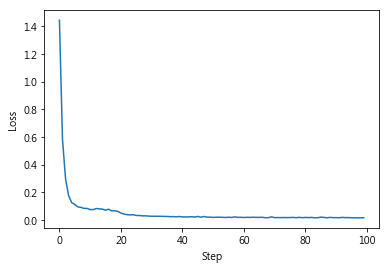

In [12]:
%matplotlib inline

import matplotlib.pyplot as plt

plt.plot(all_losses[:100])
plt.xlabel("Step")
plt.ylabel("Loss") 
plt.show()

In [13]:
# for one input
def easy_pad(easy_sent, easy_tar):
    easy_sent += [PAD_TAG for i in range(MAX_LEN-len(easy_sent))]
    easy_tar += [PAD_TAG for i in range(MAX_LEN-len(easy_tar))]
    
    return easy_sent, easy_tar

def easy_test(_input):
    _input = torch.unsqueeze(_input, 0).expand(128,100)
    return _input

def easy_output(output):
    output = output.view(128,100,5)[0].argmax(1)
    return output

In [14]:
test_content = readfile(test_data)
word_list_test, tag_list_test = split_to_list(test_content)

#===================================
easy_sent, easy_tar = easy_pad(word_list_test[3],tag_list_test[3])
input_test = prepare_sequence(easy_sent, word_to_ix)
# input_test = prepare_sequence(t_sentence, word_to_ix)

target_test = prepare_sequence(easy_tar, tag_to_ix)

_input = easy_test(input_test)

In [15]:
# Check predictions after training
with torch.no_grad():
    output = model(_input.cuda() if USE_CUDA else _input)
    output = easy_output(output)
    
    print('predict :', output)
    print('true :', target_test)
    

predict : tensor([ 4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  2,  3,  1,
         1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
         1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
         1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
         1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
         1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
         1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
         1,  1], device='cuda:0')
true : tensor([ 4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  2,  3,  1,
         1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
         1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
         1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
         1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
         1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
         1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
         1,  1])


In [16]:
def prepare_sequence__(seq, to_ix):
    gg = []
    
    for w in seq:
        if w not in to_ix:
            return seq

#     idxs = [to_ix[w] for w in seq]
#     return torch.tensor(idxs, dtype=torch.long)

def prepare_all__(seqs, to_ix):
    get_index = []
    notinseq = []
    for i in range(len(seqs)):
        a = prepare_sequence__(seqs[i], to_ix)
        if a != None:
            notinseq.append( a)
            get_index.append(i)
#         seq_list.append(prepare_sequence__(seqs[i], to_ix))
        
#     notinseq = torch.stack(notinseq)
        
    return notinseq, get_index



In [17]:
# for batch input
reserved_index_test = filter_len(word_list_test[:143])

In [18]:
len(reserved_index_test)

128

In [19]:
filter_word, filter_tag = filter_sentence(reserved_index_test, word_list_test, tag_list_test)
input_padded, target_padded = pad_all(filter_word, filter_tag)
input_var = prepare_all(input_padded, word_to_ix)
target_var = prepare_all(target_padded, tag_to_ix)

In [20]:
def total_output(output):
    output = output.view(128,100,5).argmax(2)
    return output

In [21]:
# Check predictions after training
with torch.no_grad():
    output = model(input_var.cuda() if USE_CUDA else _input)
    
    loss = criterion(output.cpu(), target_var.view(128*100))
    output = total_output(output)
    
    print('predict :', output[37])
    print('true :', target_var[37])
    print()
    print('predict :', index2tag(output[37], ix_to_tag))
    print('true :', index2tag(target_var[37], ix_to_tag))
    print()
    
    print("Loss : %.4f" % loss)

predict : tensor([ 4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,
         4,  4,  4,  4,  2,  3,  4,  4,  4,  4,  4,  4,  4,  4,
         4,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
         1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
         1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
         1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
         1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
         1,  1], device='cuda:0')
true : tensor([ 4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,
         4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,
         4,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
         1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
         1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
         1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
         1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
         1,  1])

predict : ['O', 'O', 'O', 'O', 'O',

In [22]:
input_varr, indexxx = prepare_all__(input_padded, word_to_ix)

In [23]:
indexxx

[37, 52]

In [24]:
input_padded[37]

['這',
 '次',
 'F',
 'G',
 '商',
 '品',
 '市',
 '調',
 '為',
 '美',
 '肌',
 '之',
 '誌',
 '玻',
 '尿',
 '酸',
 '肌',
 '因',
 '保',
 '濕',
 '生',
 '物',
 '纖',
 '維',
 '面',
 '膜',
 '3',
 '枚',
 '入',
 '<PAD>',
 '<PAD>',
 '<PAD>',
 '<PAD>',
 '<PAD>',
 '<PAD>',
 '<PAD>',
 '<PAD>',
 '<PAD>',
 '<PAD>',
 '<PAD>',
 '<PAD>',
 '<PAD>',
 '<PAD>',
 '<PAD>',
 '<PAD>',
 '<PAD>',
 '<PAD>',
 '<PAD>',
 '<PAD>',
 '<PAD>',
 '<PAD>',
 '<PAD>',
 '<PAD>',
 '<PAD>',
 '<PAD>',
 '<PAD>',
 '<PAD>',
 '<PAD>',
 '<PAD>',
 '<PAD>',
 '<PAD>',
 '<PAD>',
 '<PAD>',
 '<PAD>',
 '<PAD>',
 '<PAD>',
 '<PAD>',
 '<PAD>',
 '<PAD>',
 '<PAD>',
 '<PAD>',
 '<PAD>',
 '<PAD>',
 '<PAD>',
 '<PAD>',
 '<PAD>',
 '<PAD>',
 '<PAD>',
 '<PAD>',
 '<PAD>',
 '<PAD>',
 '<PAD>',
 '<PAD>',
 '<PAD>',
 '<PAD>',
 '<PAD>',
 '<PAD>',
 '<PAD>',
 '<PAD>',
 '<PAD>',
 '<PAD>',
 '<PAD>',
 '<PAD>',
 '<PAD>',
 '<PAD>',
 '<PAD>',
 '<PAD>',
 '<PAD>',
 '<PAD>',
 '<PAD>']

In [27]:
input_var[37]

tensor([  14,  113,  787,  659,  464,  287,  463,  147,  341,    4,
          34,  202,  749,  205,  206,   91,   34,   32,   12,   13,
          30,  209,  210,  185,   48,   49,  661,    0,  528,    1,
           1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
           1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
           1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
           1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
           1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
           1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
           1,    1,    1,    1,    1,    1,    1,    1,    1,    1])

In [29]:
input_padded[38]

['除',
 '了',
 '追',
 '求',
 '保',
 '濕',
 '或',
 '美',
 '白',
 '的',
 '功',
 '效',
 '外',
 '，',
 '其',
 '實',
 '是',
 '因',
 '為',
 '冰',
 '冰',
 '涼',
 '涼',
 '的',
 '很',
 '舒',
 '服',
 '~',
 '<PAD>',
 '<PAD>',
 '<PAD>',
 '<PAD>',
 '<PAD>',
 '<PAD>',
 '<PAD>',
 '<PAD>',
 '<PAD>',
 '<PAD>',
 '<PAD>',
 '<PAD>',
 '<PAD>',
 '<PAD>',
 '<PAD>',
 '<PAD>',
 '<PAD>',
 '<PAD>',
 '<PAD>',
 '<PAD>',
 '<PAD>',
 '<PAD>',
 '<PAD>',
 '<PAD>',
 '<PAD>',
 '<PAD>',
 '<PAD>',
 '<PAD>',
 '<PAD>',
 '<PAD>',
 '<PAD>',
 '<PAD>',
 '<PAD>',
 '<PAD>',
 '<PAD>',
 '<PAD>',
 '<PAD>',
 '<PAD>',
 '<PAD>',
 '<PAD>',
 '<PAD>',
 '<PAD>',
 '<PAD>',
 '<PAD>',
 '<PAD>',
 '<PAD>',
 '<PAD>',
 '<PAD>',
 '<PAD>',
 '<PAD>',
 '<PAD>',
 '<PAD>',
 '<PAD>',
 '<PAD>',
 '<PAD>',
 '<PAD>',
 '<PAD>',
 '<PAD>',
 '<PAD>',
 '<PAD>',
 '<PAD>',
 '<PAD>',
 '<PAD>',
 '<PAD>',
 '<PAD>',
 '<PAD>',
 '<PAD>',
 '<PAD>',
 '<PAD>',
 '<PAD>',
 '<PAD>',
 '<PAD>']